# Travelling Salesman Problem using Genetic Algorithm

### Importing Libraries

In [53]:
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from random import shuffle
import random
import numpy as np
import statistics
import pandas as pd
import seaborn as sns

## Data

### Cities Coordinates and Algorithm Parameters

In [54]:
x = [-5.16992,-5.18299,-5.18717,-5.19008,-5.1724,-5.15648,-5.16799,-5.17053,-5.17876,-5.17487,-5.17774,-5.16838,-5.17758,-5.20561,-5.17863,-5.18121,-5.18557,-5.17063, -5.16852,-5.17323]
y = [119.44766,119.44767,119.45603,119.41641,119.44828,119.41471,119.45341,119.44264,119.43459,119.40671,119.42831,119.41802,119.42829,119.44873,119.40675,119.43237,119.42406,119.41714,119.41937,119.41585
]
cities_names = ["ASSYIFA SALON", "INNER V SALON", "MAHA SURYA TOKO", "NONA COSMETIK", "RAHRA SALON", "RIAS TOKO", "WATNIS SALON", "YASMIN SALON", "ADHEL SALON", "ANI SALON","BARY 2 GOWA SALON","BEAUTY 8 SALON","BEN ART MANURUKI SALON","BULAN SALON GOWA","EGHY SALON","ELHA SALON, MAMOA RAYA","HERMAN DG.TATA SALON","HERMAN SALON MAPPAODDANG","IWAN KUMALA SALON","NADIA PURNAMA SALON"]
city_coords = dict(zip(cities_names, zip(x, y)))
n_population = 250
crossover_per = 0.8
mutation_per = 0.2
n_generations = 200

## Visualising Cities

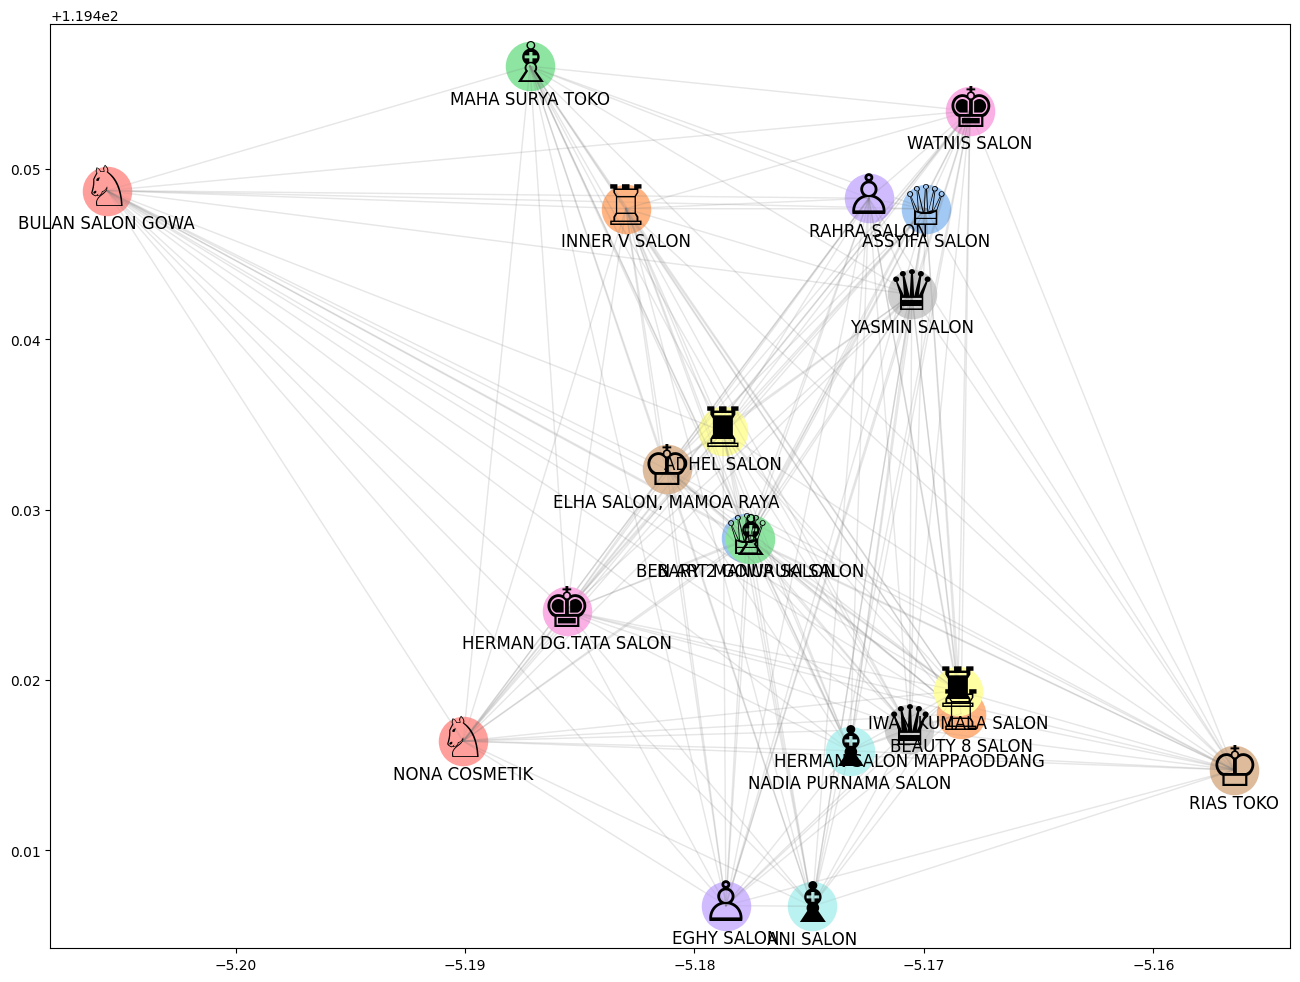

In [55]:
# Pastel Pallete
colors = sns.color_palette("pastel", len(cities_names))

# City Icons
city_icons = {
    "ASSYIFA SALON": "♕",
    "INNER V SALON": "♖",
    "MAHA SURYA TOKO": "♗",
    "NONA COSMETIK": "♘",
    "RAHRA SALON": "♙",
    "RIAS TOKO": "♔",
    "WATNIS SALON": "♚",
    "YASMIN SALON": "♛",
    "ADHEL SALON": "♜",
    "ANI SALON": "♝", 
    "BARY 2 GOWA SALON": "♕" ,
    "BEAUTY 8 SALON": "♖",
    "BEN ART MANURUKI SALON": "♗",
    "BULAN SALON GOWA": "♘",
    "EGHY SALON": "♙",
    "ELHA SALON, MAMOA RAYA": "♔",
    "HERMAN DG.TATA SALON": "♚",
    "HERMAN SALON MAPPAODDANG": "♛",
    "IWAN KUMALA SALON": "♜",
    "NADIA PURNAMA SALON": "♝",
}

fig, ax = plt.subplots()

ax.grid(False)  # Grid

for i, (city, (city_x, city_y)) in enumerate(city_coords.items()):
    color = colors[i]
    icon = city_icons[city]
    ax.scatter(city_x, city_y, c=[color], s=1200, zorder=2)
    ax.annotate(icon, (city_x, city_y), fontsize=40, ha='center', va='center', zorder=3)
    ax.annotate(city, (city_x, city_y), fontsize=12, ha='center', va='bottom', xytext=(0, -30),
                textcoords='offset points')

    # Connect cities with opaque lines
    for j, (other_city, (other_x, other_y)) in enumerate(city_coords.items()):
        if i != j:
            ax.plot([city_x, other_x], [city_y, other_y], color='gray', linestyle='-', linewidth=1, alpha=0.1)

fig.set_size_inches(16, 12)
plt.show()

## Population Function (Random Initialization)

In [56]:
def initial_population(cities_names, n_population):
    """
    Generating initial population of cities randomly selected from all possible permutations 
    of the given cities. 

    Args:
    - cities_names (list): List of city names
    - n_population (int): Number of individuals in the population

    Returns:
    - population_perms (list): List of initial population of cities
    """
    cities_list = list(cities_names)
    population_perms = []
    
    for _ in range(n_population):
        perm = list(np.random.permutation(cities_list))
        population_perms.append(perm)
    
    return population_perms

## Distance between two cities

In [57]:
def dist_two_cities(city_1, city_2):
    
    """
    Calculating the distance between two cities  
    Input:
    1- City one name 
    2- City two name
    Output:
    Calculated Euclidean distance between two cities
    """
    
    city_1_coords = city_coords[city_1]
    city_2_coords = city_coords[city_2]
    return np.sqrt(np.sum((np.array(city_1_coords) - np.array(city_2_coords))**2))
    

## Total distance traveled by individual 

In [58]:
def total_dist_individual(individual):
    
    """
    Calculating the total distance traveled by individual, 
    one individual means one possible solution (1 permutation)
    Input:
    1- Individual list of cities 
    Output:
    Total distance traveled 
    """
    
    total_dist = 0
    for i in range(0, len(individual)):
        if(i == len(individual) - 1):
            total_dist += dist_two_cities(individual[i], individual[0])
        else:
            total_dist += dist_two_cities(individual[i], individual[i+1])
    return total_dist

## Fitness probability function

In [59]:
def fitness_prob(population):
    """
    Calculating the fitness probability 
    Input:
    1- Population  
    Output:
    Population fitness probability 
    """
    total_dist_all_individuals = []
    for i in range(0, len(population)):
        total_dist_all_individuals.append(total_dist_individual(population[i]))
        
    max_population_cost = max(total_dist_all_individuals)
    population_fitness = max_population_cost - total_dist_all_individuals
    population_fitness_sum = sum(population_fitness)
    population_fitness_probs = population_fitness / population_fitness_sum
    return population_fitness_probs

## Roulette wheel

In [60]:
def roulette_wheel(population, fitness_probs):
    """
    Implement selection strategy based on roulette wheel proportionate selection. 
    Input:
    1- population
    2- fitness probabilities 
    Output:
    selected individual
    """
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    bool_prob_array = population_fitness_probs_cumsum < np.random.uniform(0,1,1)
    selected_individual_index = len(bool_prob_array[bool_prob_array == True]) - 1
    return population[selected_individual_index]

## Crossover

In [61]:
def crossover(parent_1, parent_2):
    """
    Implement mating strategy using simple crossover between 2 parents
    Input:
    1- parent 1
    2- parent 2 
    Output:
    1- offspring 1
    2- offspring 2
    """
    n_cities_cut = len(cities_names) - 1
    cut = round(random.uniform(1, n_cities_cut))
    offspring_1 = []
    offspring_2 = []
    
    offspring_1 = parent_1[0:cut]
    offspring_1 += [city for city in parent_2 if city not in offspring_1]
    
    
    offspring_2 = parent_2[0:cut]
    offspring_2 += [city for city in parent_1 if city not in offspring_2]
    
    
    return offspring_1, offspring_2
    

## Mutation

In [62]:
def mutation(offspring):
    """
    Implement mutation strategy in a single offspring
    Input:
    1- offspring individual
    Output:
    1- mutated offspring individual
    """
    n_cities_cut = len(cities_names) - 1
    index_1 = round(random.uniform(0,n_cities_cut))
    index_2 = round(random.uniform(0,n_cities_cut))

    temp = offspring[index_1]
    offspring[index_1] = offspring[index_2]
    offspring[index_2] = temp
    return(offspring)
    

## Algorithm

1. Implement the described GA algorithm to solve the traveling salesman problem.
Use a map of cities provided e.g. N = 10 and the GA parameters:
P = 250, n = 0.8, p m = 0.2, T max = 1000. What was the minimal total distance
traveled? What is the sequence of cities to be visited ensuring the minimal
total distance traveled?
2. Investigation the influence of parameters P, n and p m on the mean minimal total
distance traveled calculated for 10 trials. Change the values of P within a set
{100, 300, 500}, n ∈ {0.5, 0.7, 0.9} and p m ∈ {0.1, 0.3, 0.5}.

In [63]:
def run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per):
    
    population = initial_population(cities_names, n_population)
    fitness_probs = fitness_prob(population)
    
    parents_list = []
    for i in range(0, int(crossover_per * n_population)):
        parents_list.append(roulette_wheel(population, fitness_probs))

    offspring_list = []    
    for i in range(0,len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

    #     print(offspring_1)
    #     print(offspring_2)
    #     print()

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_1 = mutation(offspring_1)
    #         print("Offspring 1 mutated", offspring_1)

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_2 = mutation(offspring_2)
    #         print("Offspring 2 mutated", offspring_2)


        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_prob(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[0:n_population]
    best_mixed_offsrping = []
    for i in best_fitness_indices:
        best_mixed_offsrping.append(mixed_offspring[i])
        


    for i in range(0, n_generations):
        # if (i%10 == 0):
            # print("Generation: ", i)
        
        fitness_probs = fitness_prob(best_mixed_offsrping)
        parents_list = []
        for i in range(0, int(crossover_per * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offsrping, fitness_probs))

        offspring_list = []    
        for i in range(0,len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_1 = mutation(offspring_1)

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)


        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[0:int(0.8*n_population)]

        best_mixed_offsrping = []
        for i in best_fitness_indices:
            best_mixed_offsrping.append(mixed_offspring[i])
            
        old_population_indices = [random.randint(0, (n_population - 1)) for j in range(int(0.2*n_population))]
        for i in old_population_indices:
#             print(i)
            best_mixed_offsrping.append(population[i])
            
        random.shuffle(best_mixed_offsrping)
            
    return best_mixed_offsrping

In [64]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)

In [65]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))

In [66]:
index_minimum = np.argmin(total_dist_all_individuals)

### Optimum Solution

In [67]:
minimum_distance = min(total_dist_all_individuals)

In [68]:
minimum_distance

0.19362650466206152

#### Optimum Solution is the distance of 61.137

In [69]:
# shortest_path = offspring_list[index_minimum]
shortest_path = best_mixed_offsrping[index_minimum]

In [70]:
shortest_path

['BEN ART MANURUKI SALON',
 'BARY 2 GOWA SALON',
 'ELHA SALON, MAMOA RAYA',
 'ADHEL SALON',
 'BULAN SALON GOWA',
 'MAHA SURYA TOKO',
 'INNER V SALON',
 'RAHRA SALON',
 'WATNIS SALON',
 'ASSYIFA SALON',
 'YASMIN SALON',
 'RIAS TOKO',
 'IWAN KUMALA SALON',
 'BEAUTY 8 SALON',
 'HERMAN SALON MAPPAODDANG',
 'NADIA PURNAMA SALON',
 'ANI SALON',
 'EGHY SALON',
 'NONA COSMETIK',
 'HERMAN DG.TATA SALON']

### Optimum Solution Visualization

In [71]:
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    
x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

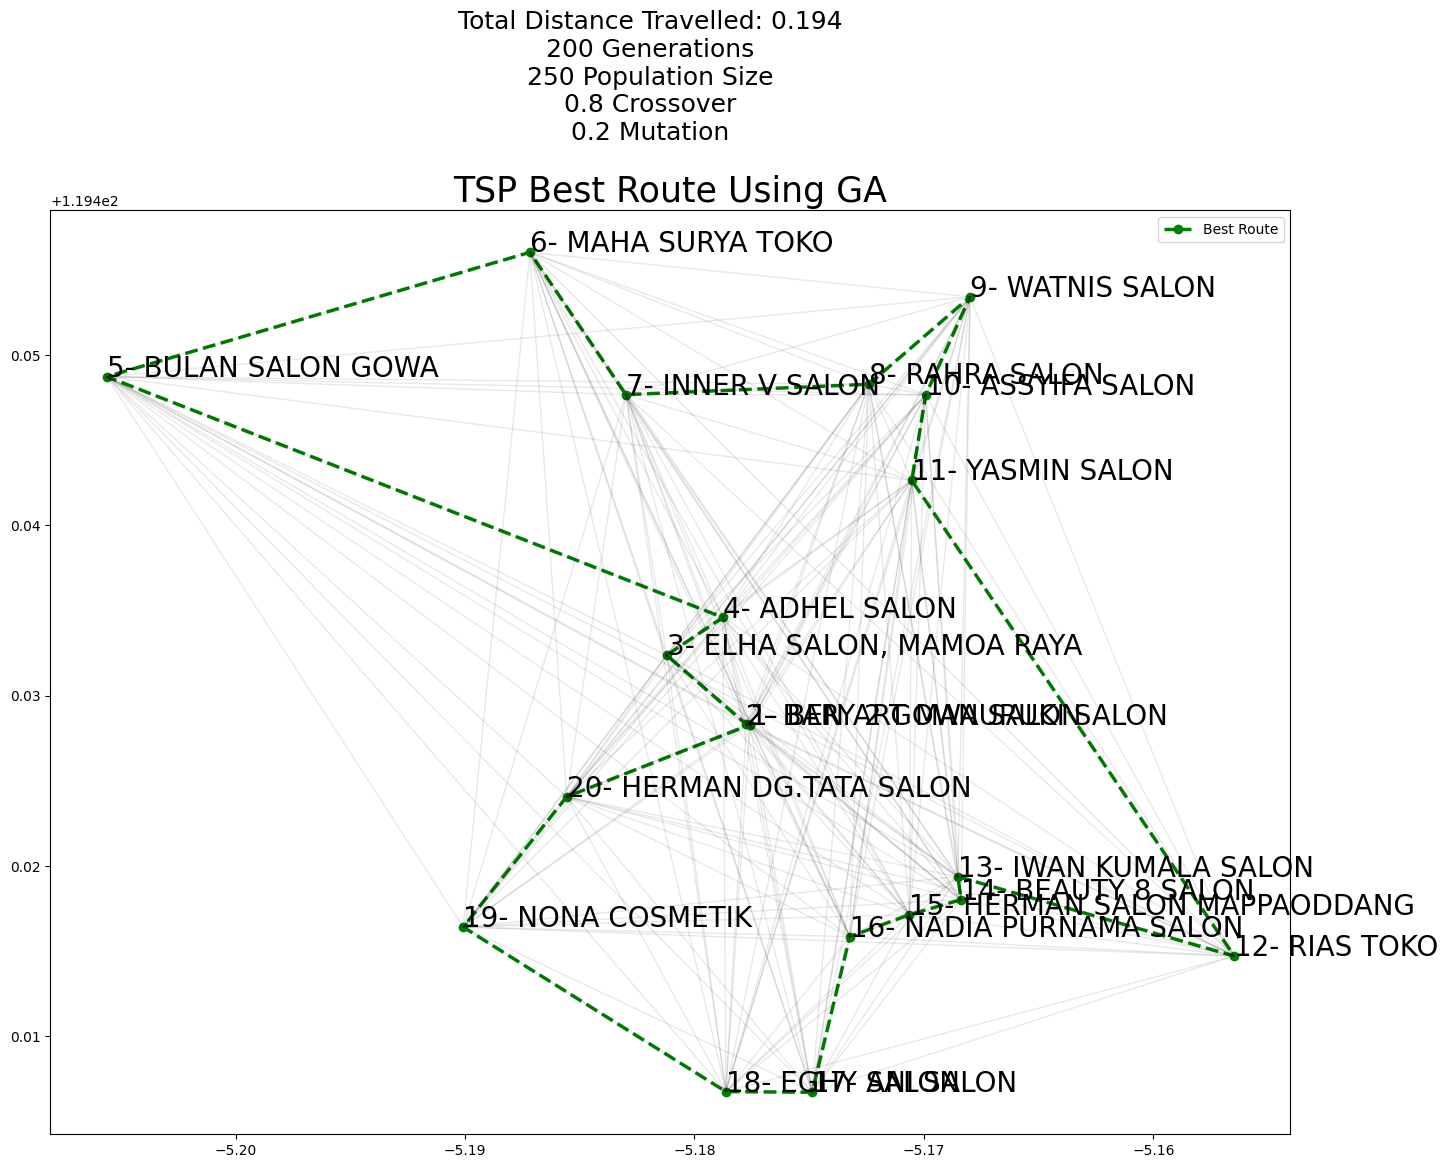

In [72]:
fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)
        
plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
plt.suptitle("Total Distance Travelled: "+ 
             str(round(minimum_distance, 3)) + 
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)    
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()

## Parameters Influence

Investigation of the influence of parameters P, n and p m on the mean minimal total
distance traveled calculated for 10 trials. Change the values of P within a set
{100, 300, 500}, n ∈ {0.5, 0.7, 0.9} and p m ∈ {0.1, 0.3, 0.5}.

In [73]:
n_population_range = [100, 300, 500]
crossover_per_range = [0.5, 0.7, 0.9]
mutation_per_range = [0.1, 0.3, 0.5]
n_trials = 10

n_population_chosen = []
crossover_per_chosen = []
mutation_per_chosen = []
minimium_total_distance_10_iter = []
mean_minimium_total_distance = []

In [74]:
for n_population in n_population_range:
    for crossover_per in crossover_per_range:
        for mutation_per in mutation_per_range:
            for i in range(0, n_trials):
                best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)
                total_dist_all_individuals = []
                for i in range(0, n_population):
                    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))
                index_minimum = np.argmin(total_dist_all_individuals)
                minimium_total_distance_10_iter.append(min(total_dist_all_individuals))
            mean_minimium_total_distance.append(statistics.mean(minimium_total_distance_10_iter))
            n_population_chosen.append(n_population)
            crossover_per_chosen.append(crossover_per)
            mutation_per_chosen.append(mutation_per)

In [75]:
parameters_analysis_df = pd.DataFrame(list(zip(n_population_chosen,
                                               crossover_per_chosen,
                                               mutation_per_chosen,
                                               mean_minimium_total_distance)),
               columns =['n population', 
                         'crossover %',
                         'mutation %',
                         'avg min total distance'])

## Parameters Analysis

In [76]:
parameters_analysis_df

,n population,crossover %,mutation %,avg min total distance
0,100,0.5,0.1,0.354309
1,100,0.5,0.3,0.357971
2,100,0.5,0.5,0.357527
3,100,0.7,0.1,0.327348
4,100,0.7,0.3,0.305699
5,100,0.7,0.5,0.295685
6,100,0.9,0.1,0.283919
7,100,0.9,0.3,0.275727
8,100,0.9,0.5,0.268236
9,300,0.5,0.1,0.274760


## Conclusion and Final Notes:


    The previous analysis is held with 200 generation and took 55 mins to finish the 270 runs
    and supposedly as we increase the number of generations the mean of total distance will 
    decrease and also we're sure that the optimum solution as seen above, can be found
    in the minimum of the 10 runs per each combination.


    The 270 runs can be broken down as follows: 27 combinations generated from the 3 different
    parameters with 3 different values for each parameter. each combination is ran 10 times
    and the mean of the minimum distance travelled is calculated.

    From the table above it's clear that with low population and low crossover percentage,
    the algorithm may need more generation to converge.
    As the number of population increases and crossover percentage increase it's more
    likely to approach the optimum solution. Also increasing mutation percentage can refine
    the algorithm performance when crossover percentage is limited. 
    And the best results came when population and crossover percentages were high.
    It's also likely that with suffiecient number of generations, optimum solution can appear
    more frequently when both the population size and the crossover percentages are high.